<a href="https://colab.research.google.com/github/smnieee/ml_workshop/blob/master/BiomedClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brief introduction to advanced techniques in Clustering.**

NOTE:  This notebook is largely based on the tutorial found here:
https://exeter-data-analytics.github.io/MachineLearning/clustering.html

All images (and much of the text) herein are from the original tutorial.  The original authors get full credit for this entire notebook.

The following image is generated from a microarray experiment:

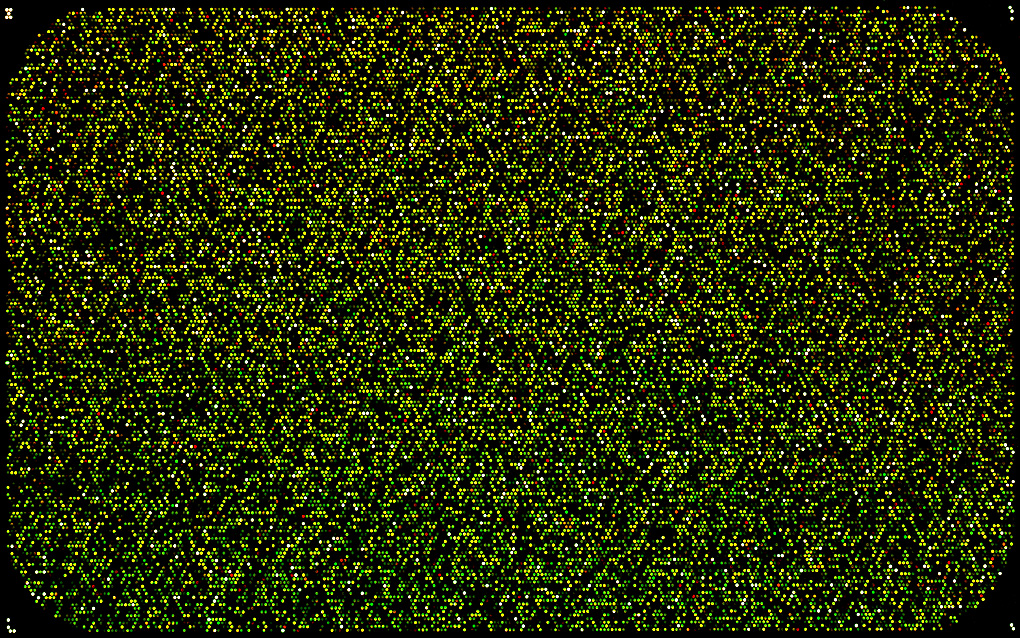

Microarray technology is used to detect gene activity from a biological sample.
Each dot in the image is a seperate "detector" which interacts with the biological sample placed in each well.  The intensity value for each dot represents a measurment of gene expression activity (i.e. is the gene active?)

More details on the method can be found here:

https://www.nature.com/scitable/definition/microarray-202/#:~:text=A%20microarray%20is%20a%20laboratory,known%20DNA%20sequence%20or%20gene.


The activity of any one gene is not particularly interesting in most cases.  It is actually the activity of multiple genes at the same time that indicates an interesting biological finding.  As the original author notes, there are two questions that we might ask of this data:

1.   Which genes are co-regulated, that is, behave in the same way? (within a sample)

2.   Which individuals are similar to each other, that is, have a similar gene expression profile? (between independent samples)

We will be using some microarray data that contains >12k genes for 128 people.  The goal of this exercise is to look for common patterns among the 128 people (i.e. cluster the people into groups).

# **Downloading Dataset to your computer**

This link will save the data to your local computer:
https://exeter-data-analytics.github.io/MachineLearning/data.zip

After it downloads, it will show up at the bottom of your screen (Chrome).  Click on the up arrow and select "Show in Folder"

**Note the folder that the data.zip file is located in.**

In [ ]:
import pandas as pd
from io import BytesIO
from google.colab import files
from zipfile import ZipFile



In [ ]:
# When you run this cell, it will create a "Choose Files" button.
# Click the button and select the data.zip file

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.zip to data (2).zip
User uploaded file "data.zip" with length 12836020 bytes


In [ ]:
# This method is not being used.
# There is no need to click run on this cell

#from google.colab import drive
#drive.mount('/content/drive')
#xTrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_data/gene_expression.csv', header=0, index_col=0)
#print(xTrain.shape)

In [ ]:
# This cell will open the zip file and load the gene data
file = ZipFile(BytesIO(uploaded['data.zip']))

#for filename in file.namelist():
#    print('File:', filename)

gene_csv = file.open("_data/gene_expression.csv")
xTrain = pd.read_csv(gene_csv, header=0, index_col=0)

print(xTrain.shape)


(12625, 128)


# **Choosing the k for k-means clustering:**

As noted earlier, k-means requires knowing the number of clusters in the data.  It is rarely the case that we know the number of clusters.  If we did, then this wouldn't be a very interesting analysis.

To help identify the number of clusters, you can simply look at the performance across several k values:

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# CHANGE ME TO SOMETHING LARGER:
maxRange=3

# Initialise some variables
kRange = range(2, maxRange)
intra = np.empty(len(kRange)) # intracluster sum-of-squares
inter = np.empty(len(kRange)) # intercluster sum-of-squares

# Loop across desired range of ks
for k in kRange:
    mdl = KMeans(n_clusters=k)
    mdl.fit(X=xTrain)
    intra[k-2] = mdl.inertia_  # it’s (k-2) because k starts from 2
    inter[k-2] = np.sum(scale(xTrain, with_std=False)**2) - mdl.inertia_

Text(0, 0.5, 'Sum-of-squares')

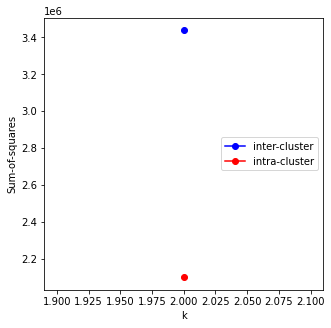

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(kRange, inter, 'bo-', label='inter-cluster')
plt.plot(kRange, intra, 'ro-', label='intra-cluster')
plt.legend(loc='center right')
plt.xlabel('k')
plt.ylabel('Sum-of-squares')

The plot shows the inter-cluster vs intra-cluster value for each k in the range from 2 to 9.  Ideally, the algorithm should be maximizing the difference between clusters and minimizing the difference within clusters. Thus, we are looking for the greatest difference between the two.

It is not surprising that these are asymptotic curves.  There is diminishing returns as the number of clusters increases.

# **Gaussian Mixture Models:  A Distribution based approach to classification**

K-means is based on the distance between samples (this is a geometric approach).  Consider an alternative strategy where the algorithm looks at the distribution of values for all of the data.  In doing so, the algorithm can identify the optimal splitting point between clusters.  Moreover, because this is a statistical method, it is more likely to be robust to noise/outliers.

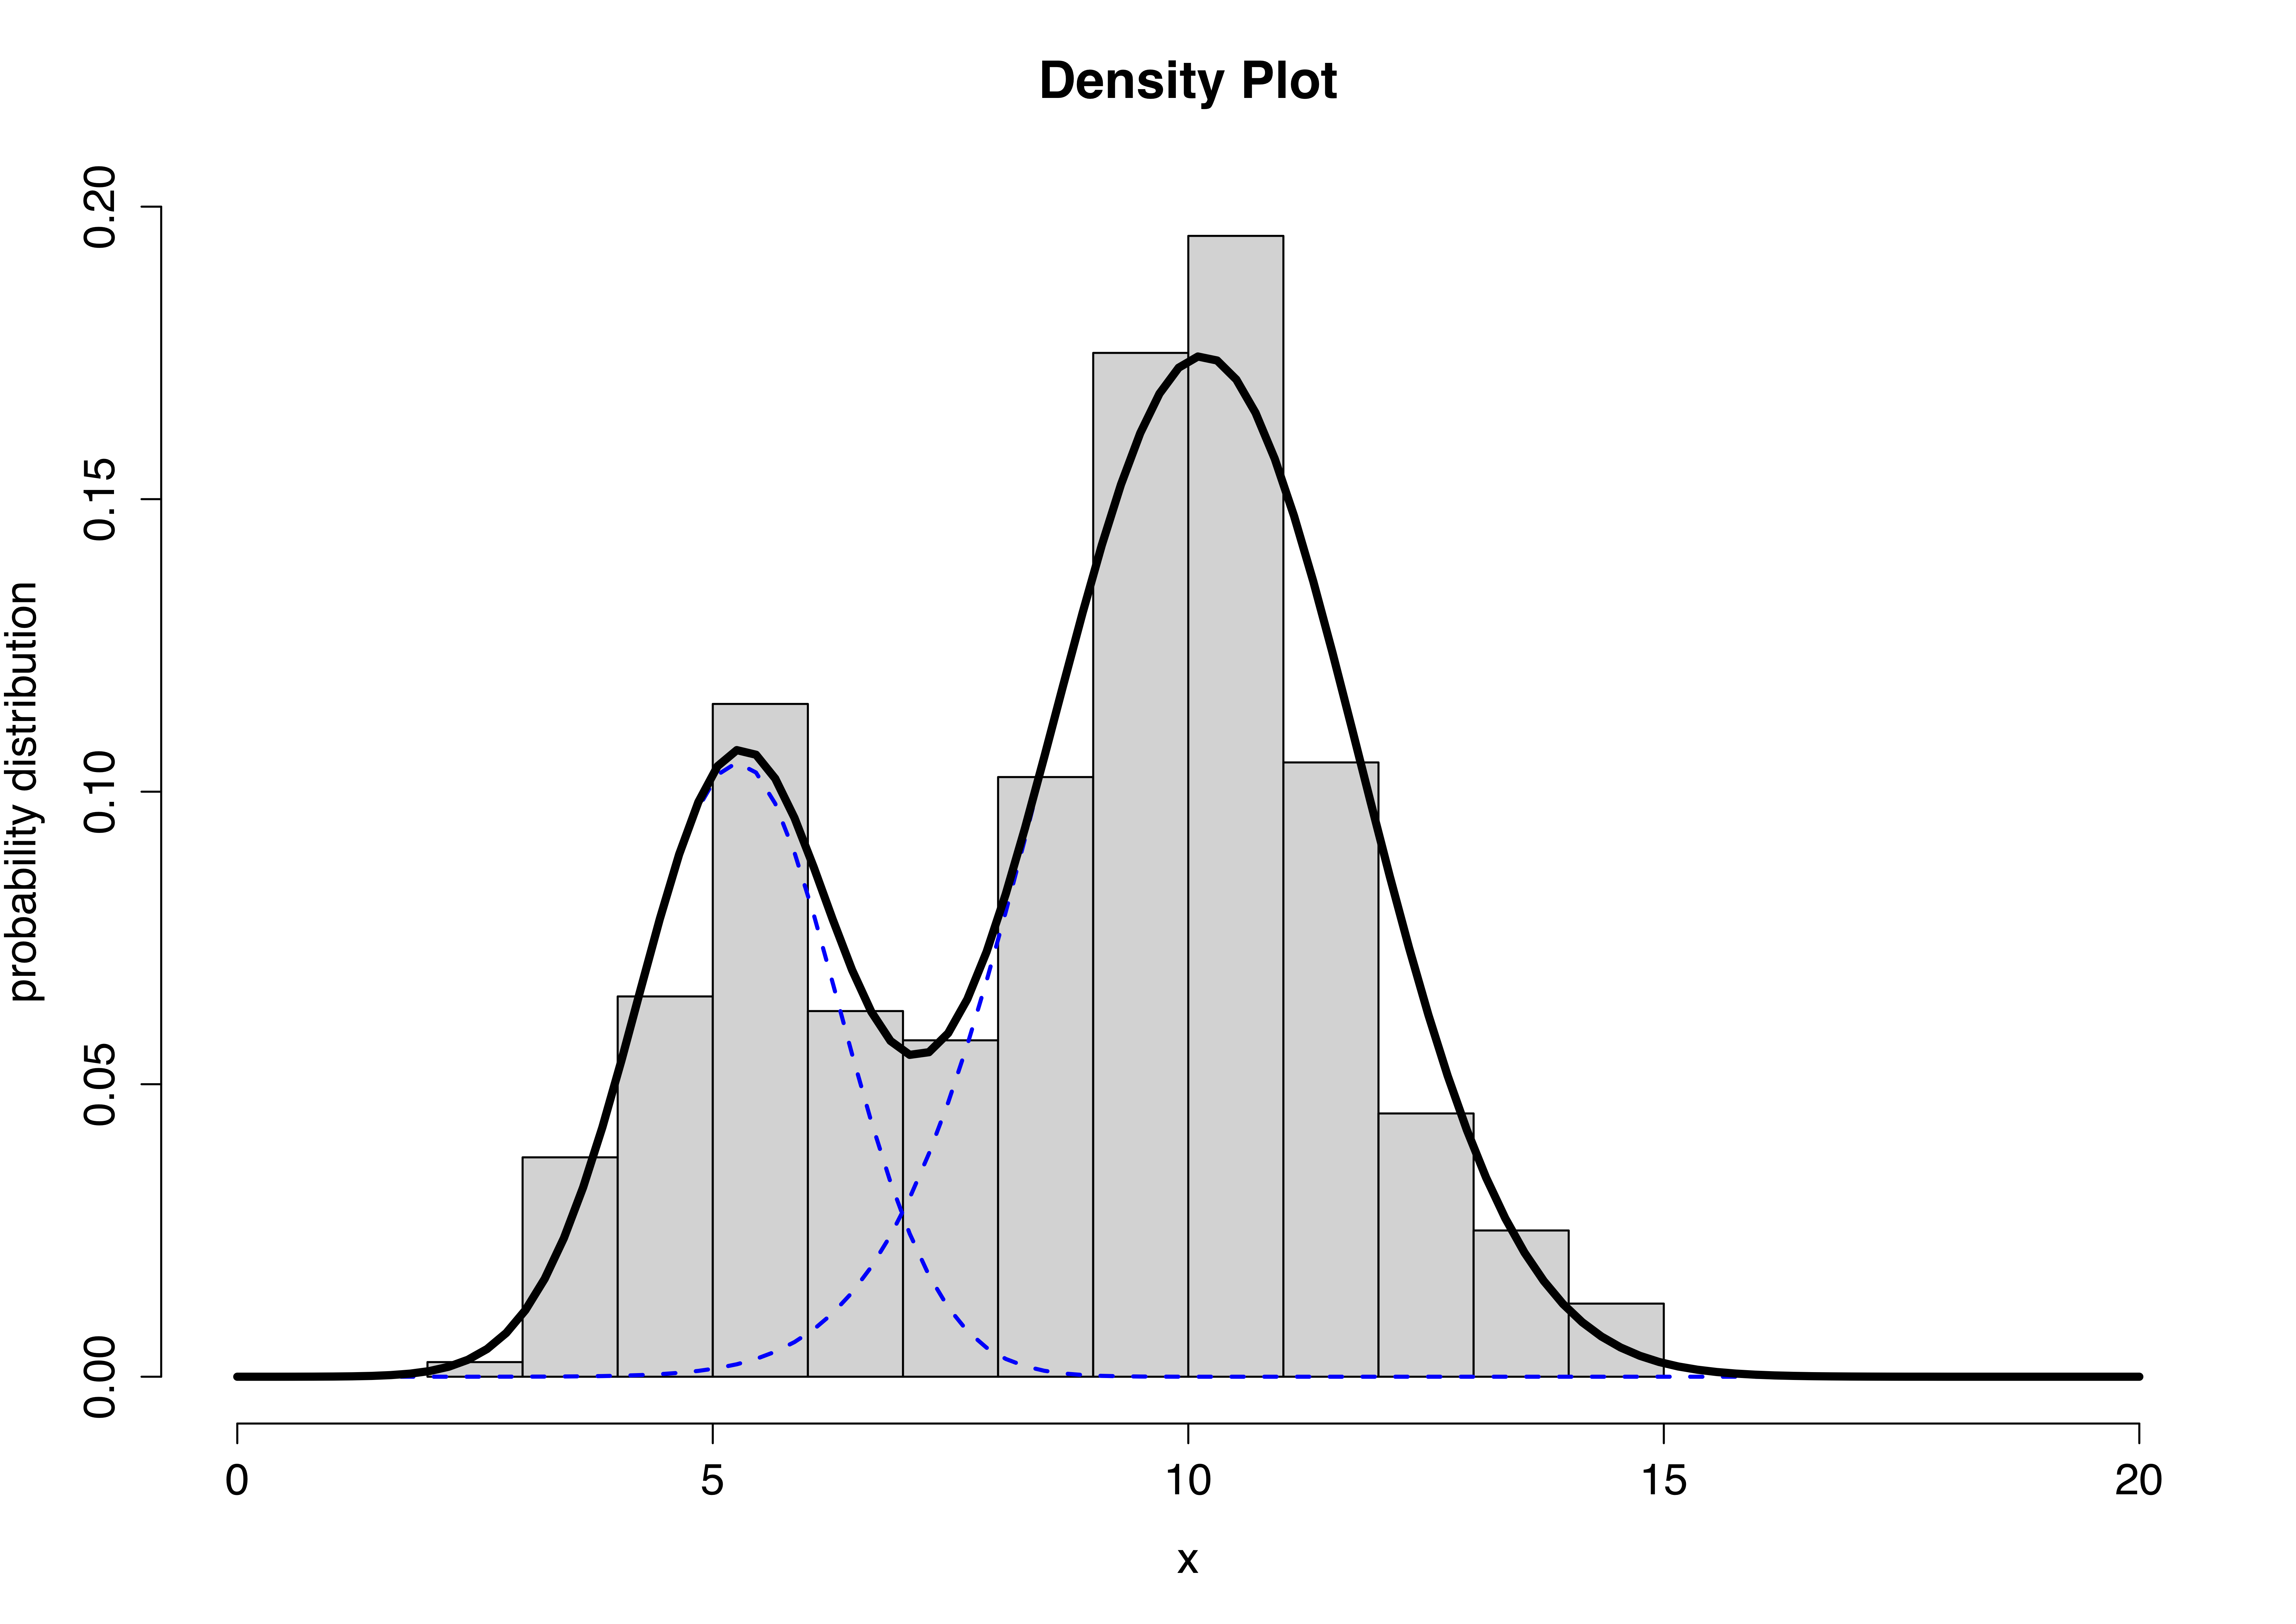

Unfortunately, while this is a robust method, it still requires defining/knowing the number of clusters ahead of time.

GMM are available in sklearn as well.  

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

# CHANGE ME TO SOMETHING LARGER:
maxRange=3

# Initialise some variables
kRange = range(2, maxRange)
AIC = np.empty(len(kRange)) # Akaike information criterion

# Loop across desired range of ks
for k in kRange:
    mdl = GMM(n_components=k)
    mdl.fit(X=xTrain)
    AIC[k-2] = -mdl.aic(xTrain)

# Plot inter/intercluster sum-of-squares as a function of $k$

Conceptually, these distribution models are trying to attain the same goal ... maximizing the inter-cluser distance.  However, because they are statistical in nature, there are more mathematical tools that can help quantify how good a model fits the data.  In this next section, we will plot the Akaike Information Criterion (AIC).  This value will peak out for the best model and then start to drift away from the best model.

Text(0, 0.5, 'Information criterion')

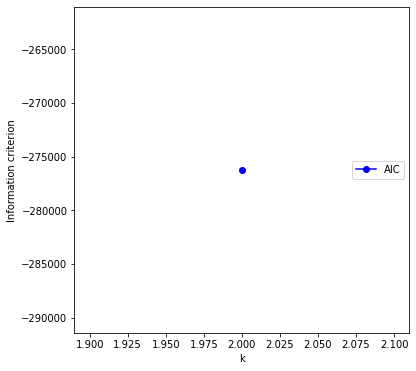

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(kRange, AIC, 'bo-', label='AIC')
plt.legend(loc='center right')
plt.xlabel('k')
plt.ylabel('Information criterion')

# **Hierarchical Clustering:  A strategy requiring less information ... returning less information(?)**

Hierarchical clustering removes the need to estimate the specific number of clusters *a priori*.  Instead, the algorithm attempts to look at all of the data and consider all of the possible cluster outcomes.  While this is computationally intensive, it avoids the need to make assumptions about the data.

In this method, each data point is initialized as its own cluster.  The algorithm finds the clusters that are closest together and merges them.  The process is repeated until all of the clusters are merged into a single cluster.

The result of this algorithm is tree that shows all of the clusters and the merging between clusters.



**Computing distance:**

Like all clustering methods, a distance function is used to compute the similarity between samples.  The following figure shows two common distances.  Another distance, the canberra distance, is a weighted cityblock distance.




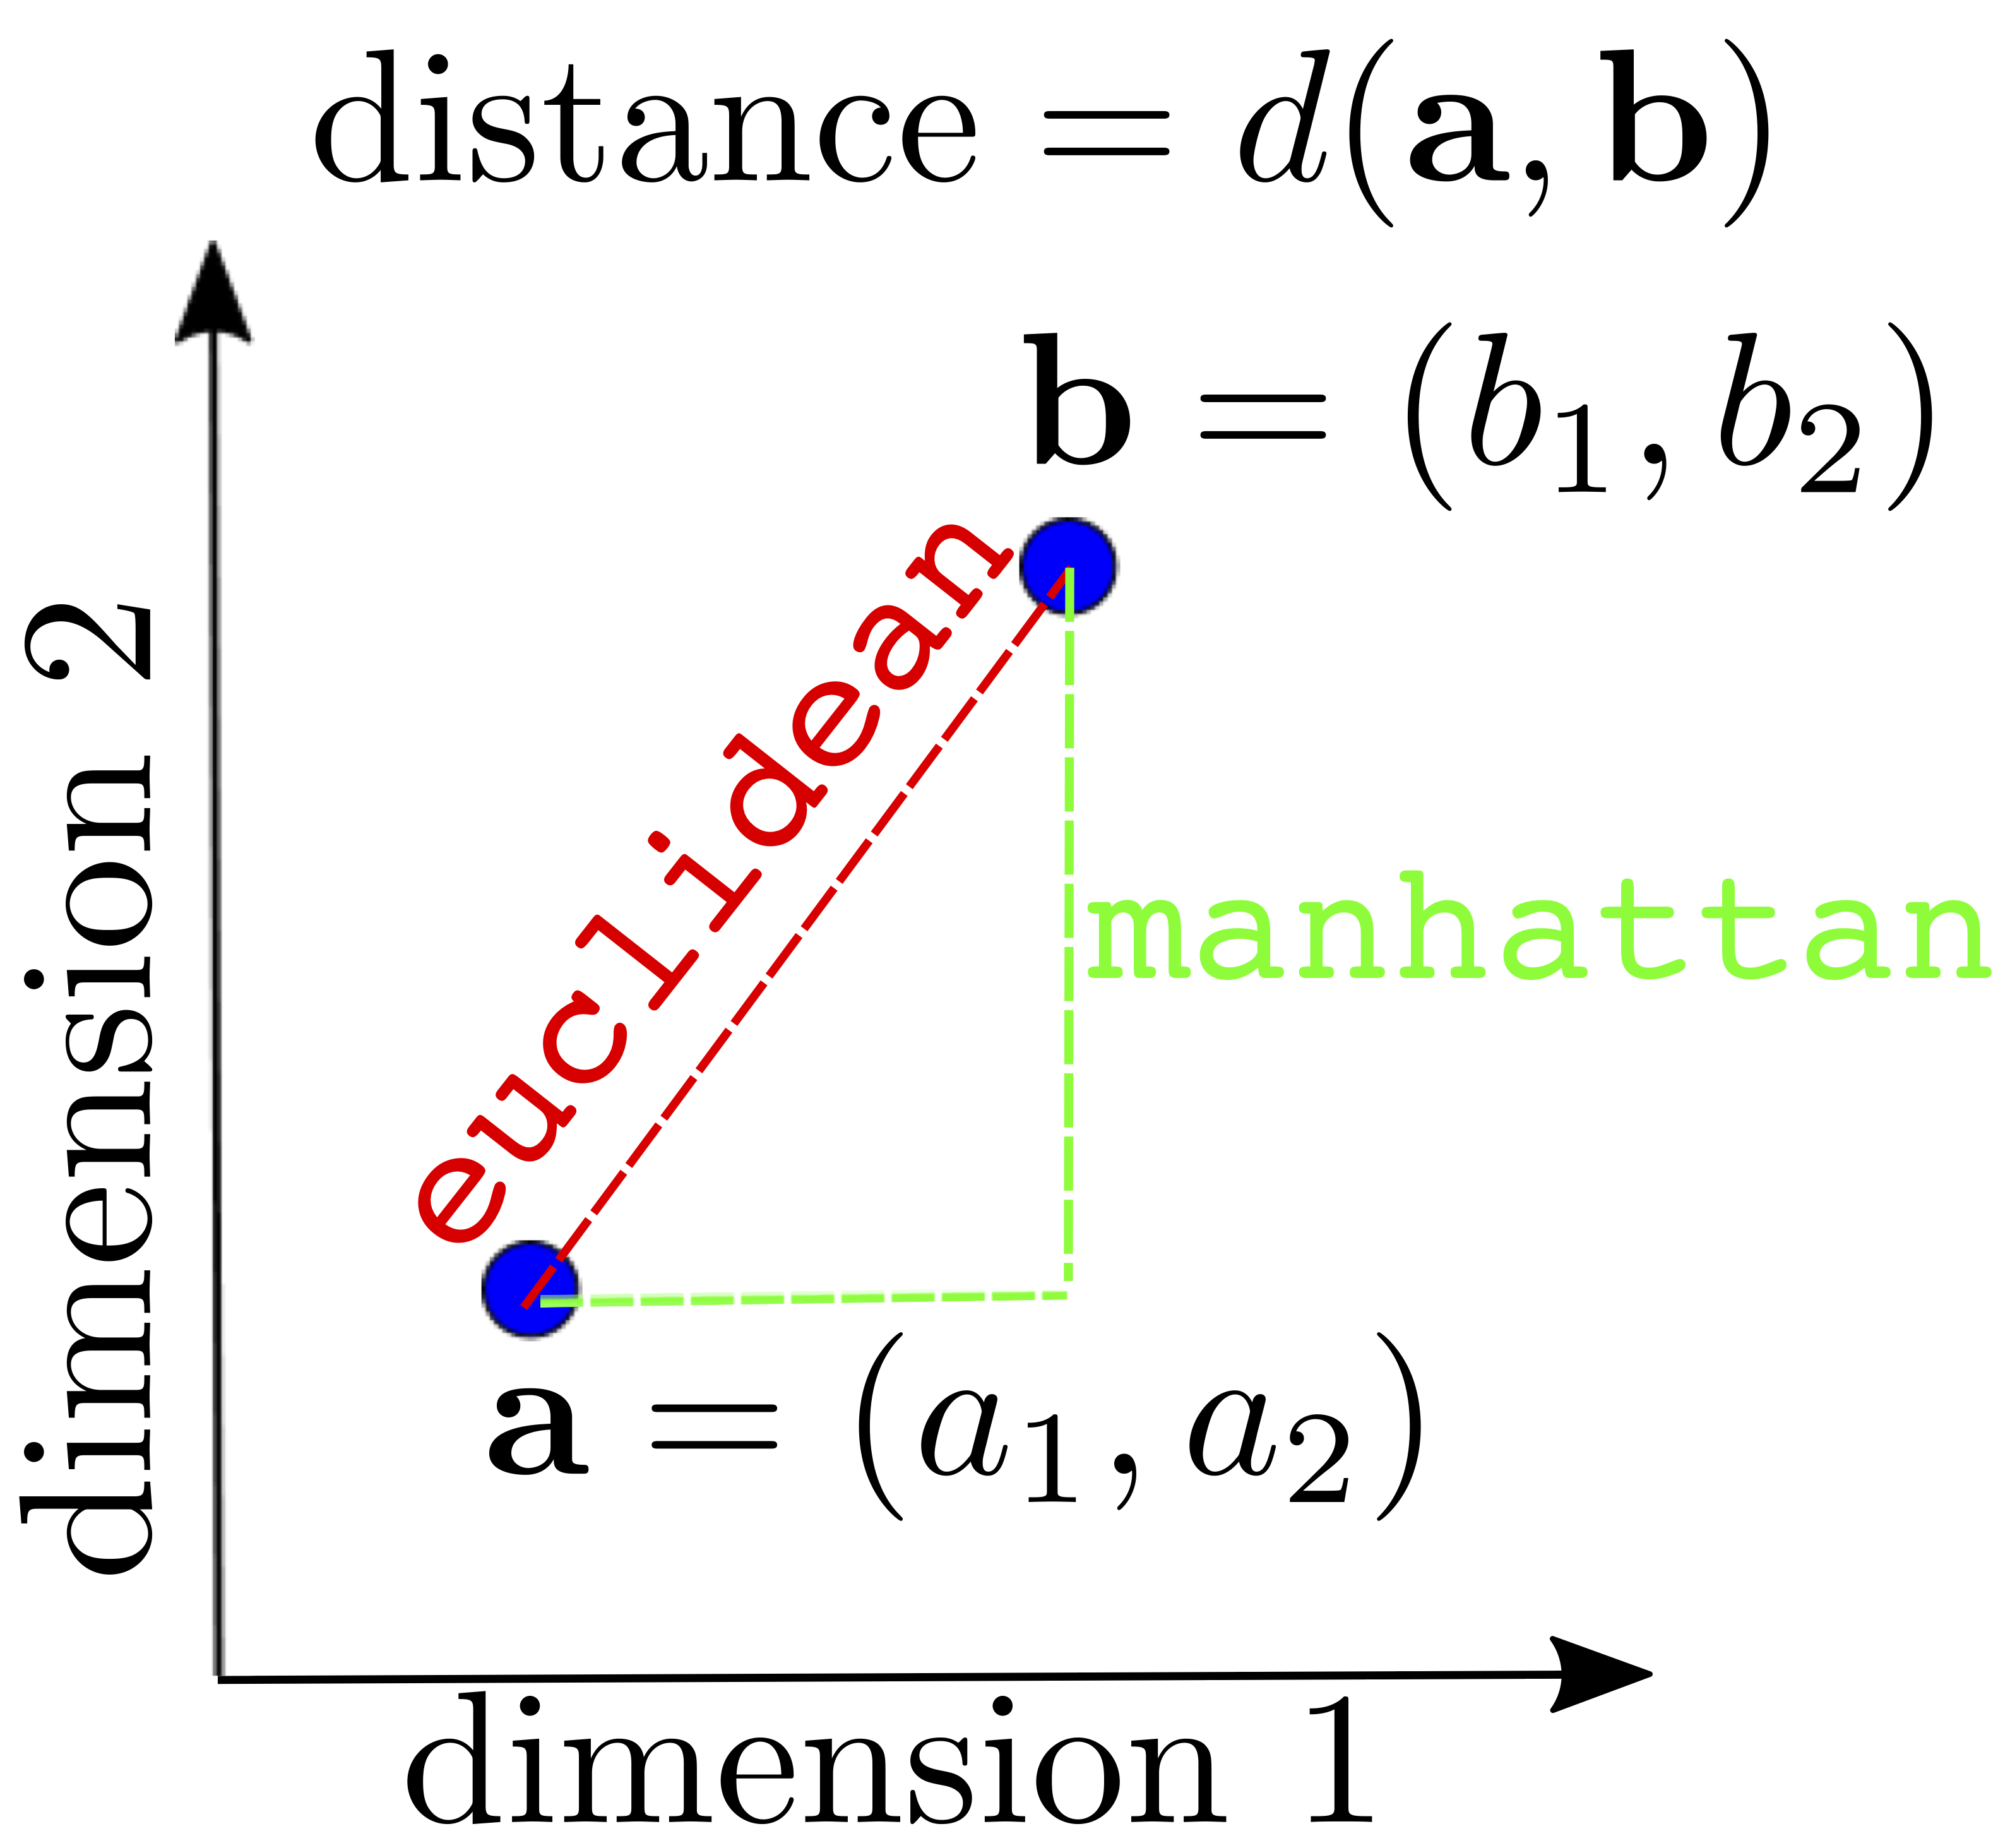

**Defining a Cluster:**

Because the clusters are built up dynamically, a method for defining the cluster (in order to compute the distance) must be selected.  These are some of the methods:

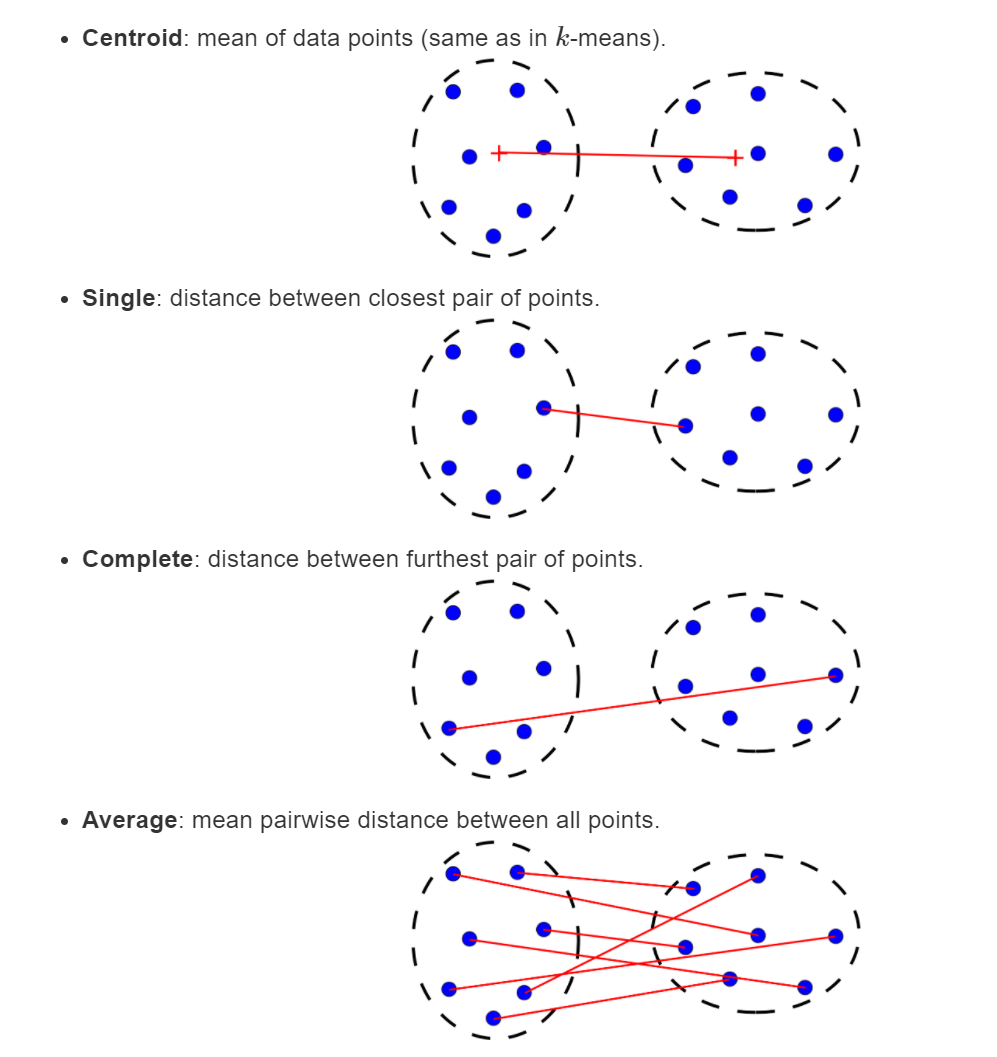

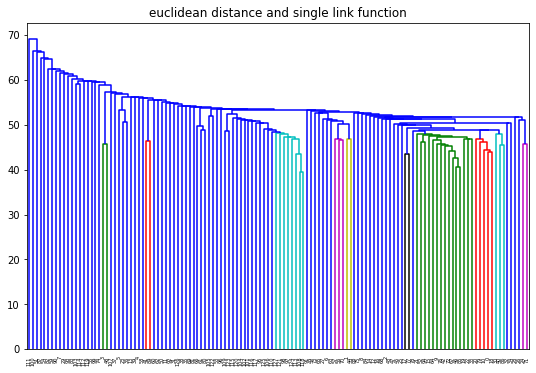

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# SET THESE VALUES BETWEEN 0 AND 2
link = 0
dist = 0

linkMethod = ['single','complete','average']
distMethod = ['euclidean','cityblock','canberra']
distance = pdist(X=xTrain.T, metric=distMethod[dist] )

mdl = linkage(distance, method=linkMethod[link])
plt.figure(num=linkMethod[link], figsize=(9,6))
dendrogram(mdl)
plt.title('{0} distance and {1} link function'.format(distMethod[dist], linkMethod[link]))
plt.show()

**Looking at dendrograms:**

The dendrogram is the map that shows how the algorithm built up the clusters.  The x-axis is each of the samples.  The y-axis shows the merging of the clusters into parent clusters.  The y-axis value is the distance at which the clusters merged.

While visually compelling, the hierarchical clustering method can be difficult to interpret on its own.  It is not clear at what level to "threshold" the data into seperate clusters.

This method is best suited when there is ancillary data available to corroborate/interpret the data.